FASTAI 4 DEM - EPSCN
=========================
EPSCN: Real-Time Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolution Neural

**This is only a template, no better results could be achieved than with a simple bicubic upsampling.**

If you achieve any proper results please get in contact.

The implementation is based on  https://github.com/benymd/super_resolution.

Paper: https://arxiv.org/abs/1609.05158


# Data

Download the training and test data of the austrian DTM: https://www.openmaps.online/data/austria_dtm_fastai.zip

License: Data by - Geoland.at (2019) - CC BY 4.0 (CC BY 4.0)

High resolution images: 300*300px

Low resolution image: 100*100px

Upsampled to 300*300px with next neighbor or bicubic method

**Upsampling is done by the algorithm here.**


# Setup

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
!pip install rasterio

# Data Loader

In [6]:
# adapt this parameter to the maximum height of your training dataset
max_height = 3150
# adapt the folder name to the low resolution images 
LR_PATH_TRAIN = "/content/gdrive/MyDrive/fastai/data_100/lr"

In [7]:
# read geotiffs
import rasterio
from fastbook import *
from fastai.vision import *

def raster2tensor(image):  
    f = rasterio.open(image)
    d1 = f.read(1)
    tensorImage = TensorImage([d1])
    # adapt 
    tensorImage = tensorImage / max_height
    return tensorImage

def raster2tensorHr(image):  
    # adapt to replace the folder name to the high resolution images 
    image = str(image).replace("lr", "hr")
    f = rasterio.open(image)
    d1 = f.read(1)
    tensorImage = TensorImage([d1])
    tensorImage = tensorImage / max_height
    return tensorImage 

In [8]:
# valid_pct = percent of the total images that is used for validation 
db = DataBlock(blocks=(TransformBlock(type_tfms=raster2tensor),
                       TransformBlock(type_tfms=raster2tensorHr),
                      ),
               get_items = get_image_files,
               splitter=RandomSplitter(valid_pct=0.1, seed = 42)
              )

In [9]:
dls = db.dataloaders(source=LR_PATH_TRAIN, bs=12, num_workers=2)

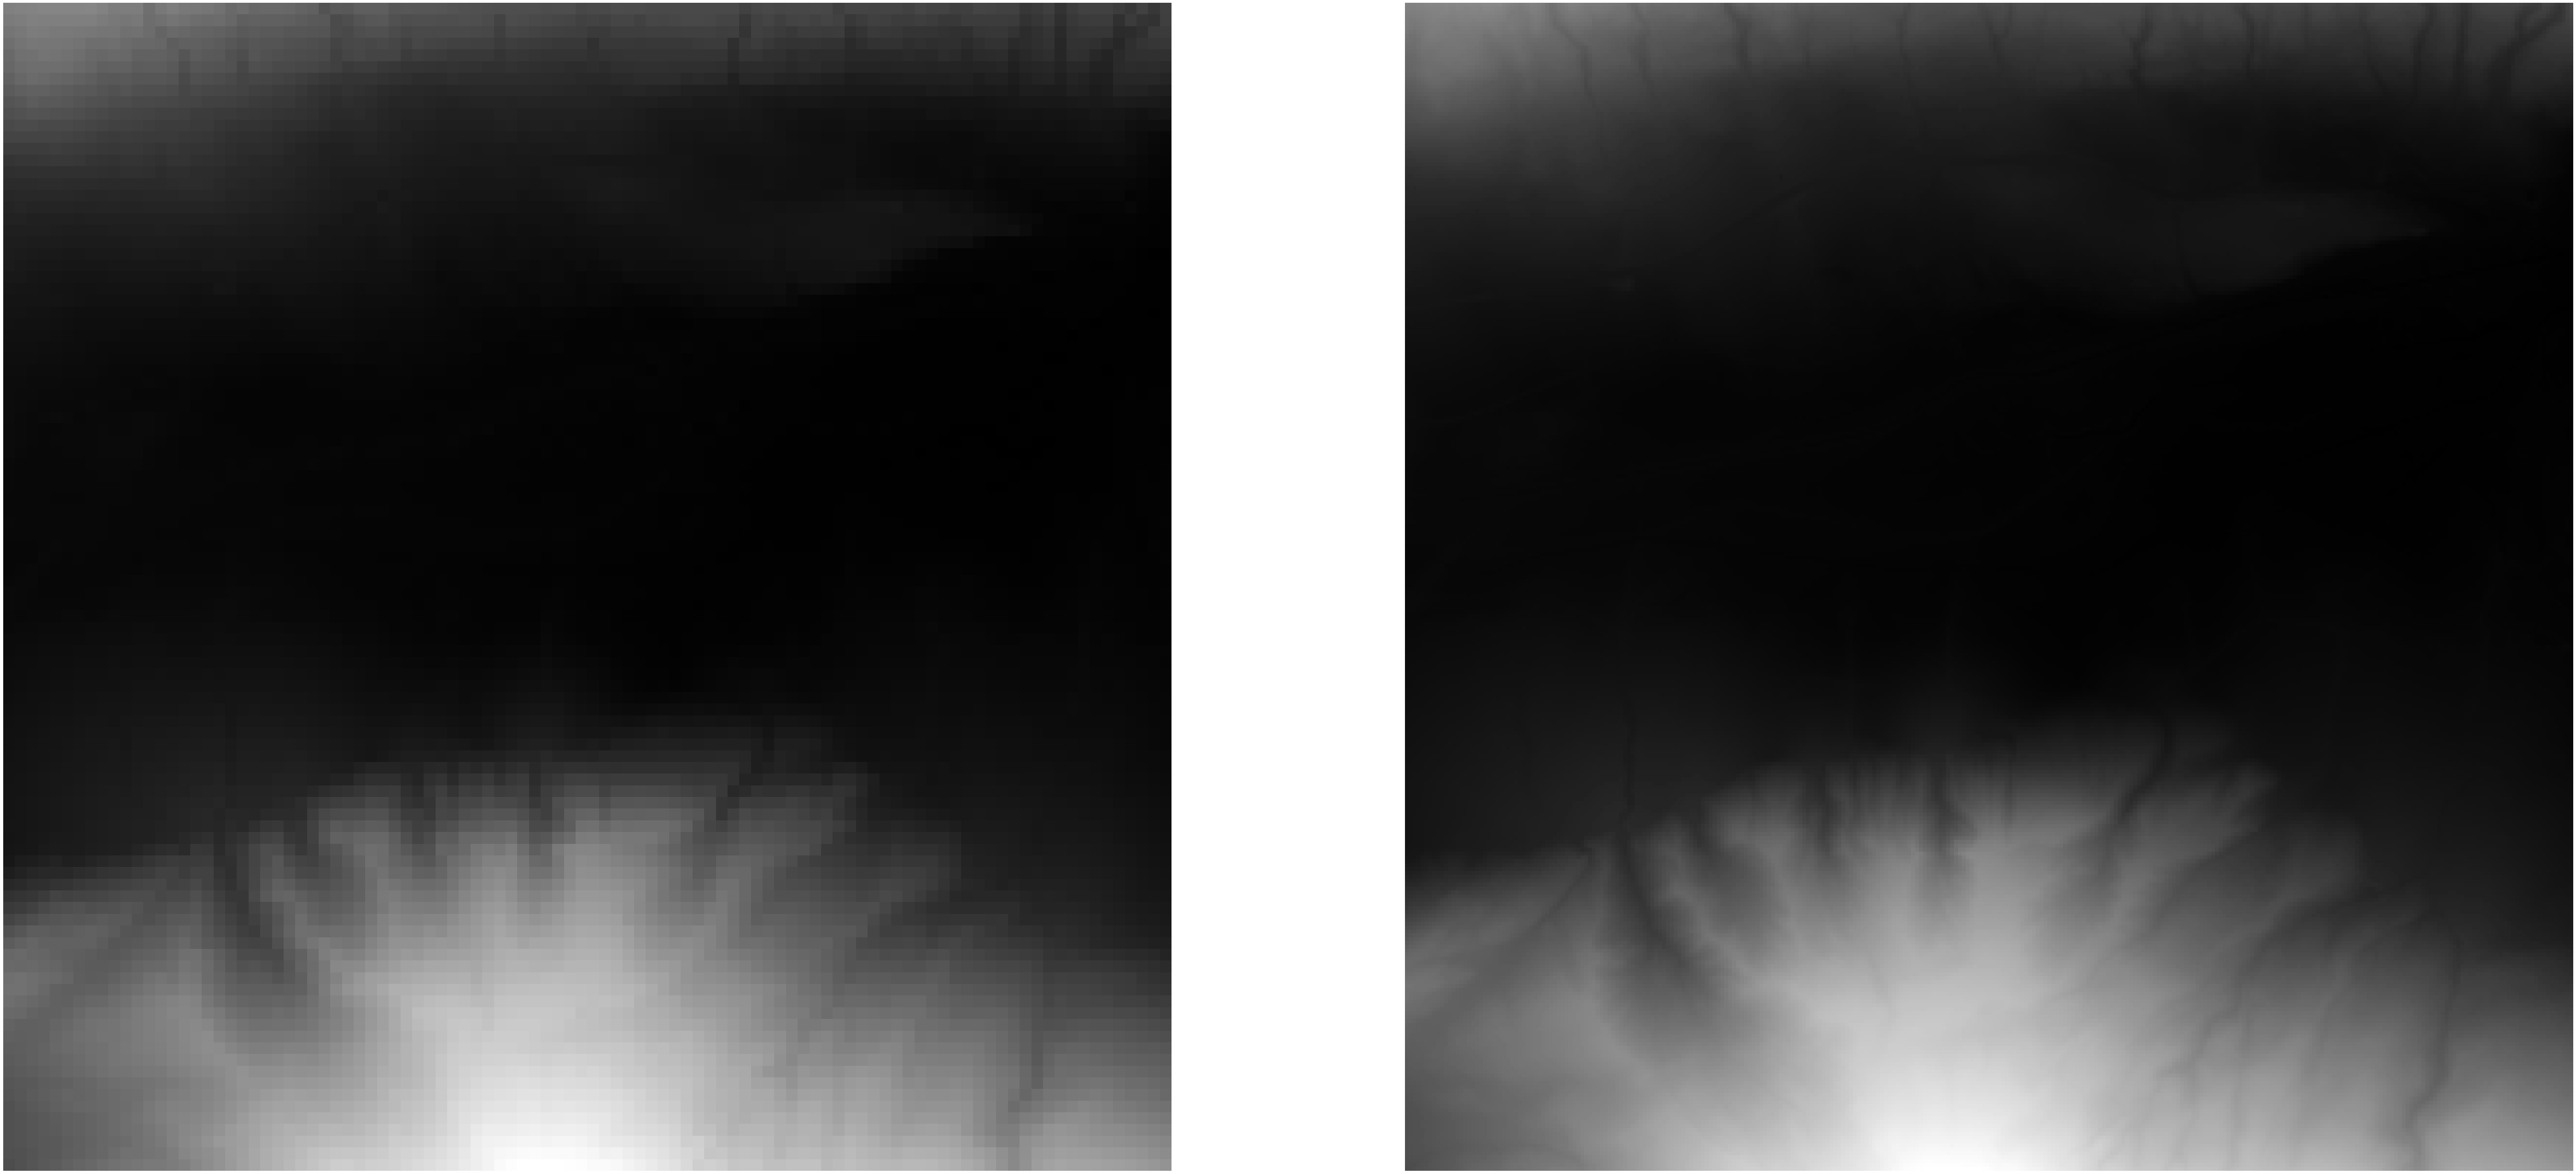

In [10]:
dls.show_batch(max_n = 1, cmap='gray', figsize = (100,100))

In [11]:
# Shows the values
dls.one_batch()

(TensorImage([[[[0.3222, 0.3294, 0.3343,  ..., 0.2781, 0.2735, 0.2679],
           [0.3107, 0.3149, 0.3223,  ..., 0.2784, 0.2743, 0.2685],
           [0.3058, 0.3083, 0.3112,  ..., 0.2786, 0.2741, 0.2687],
           ...,
           [0.3327, 0.3292, 0.3266,  ..., 0.3340, 0.3349, 0.3358],
           [0.3307, 0.3278, 0.3257,  ..., 0.3386, 0.3386, 0.3387],
           [0.3289, 0.3264, 0.3248,  ..., 0.3408, 0.3424, 0.3432]]],
 
 
         [[[0.6185, 0.6143, 0.6095,  ..., 0.4551, 0.4496, 0.4446],
           [0.6190, 0.6157, 0.6109,  ..., 0.4558, 0.4480, 0.4417],
           [0.6200, 0.6170, 0.6116,  ..., 0.4518, 0.4463, 0.4426],
           ...,
           [0.5789, 0.5941, 0.5881,  ..., 0.7521, 0.7588, 0.7557],
           [0.5759, 0.5900, 0.5858,  ..., 0.7597, 0.7640, 0.7596],
           [0.5699, 0.5779, 0.5716,  ..., 0.7668, 0.7631, 0.7590]]],
 
 
         [[[0.1770, 0.1778, 0.1787,  ..., 0.2116, 0.2117, 0.2116],
           [0.1766, 0.1774, 0.1781,  ..., 0.2124, 0.2124, 0.2121],
           [0

# Random

In [12]:
# Taming the random

import random
import numpy as np
import torch

from fastai.vision import *


def set_seeds():
    random.seed(42)
    np.random.seed(12345)
    torch.manual_seed(1234)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()    

# EPSCN

In [13]:
class EPSCN(nn.Module):
  
    def __init__(self, upscale=2):
        super(EPSCN, self).__init__()
        self.upscale = upscale
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, upscale ** 2, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(self.upscale)

    def _initialize_weights(self):
        weights_with_relu = [
            self.conv1.weight,
            self.conv2.weight,
            self.conv3.weight
        ]

        for w in weights_with_relu:
            nn.init.orthogonal_(w, nn.init.calculate_gain('relu'))

        nn.init.orthogonal_(self.conv4.weight)

    def forward(self, x):
        h = torch.tanh(self.conv1(x))
        h = torch.tanh(self.conv2(h))
        h = torch.tanh(self.conv3(h))
        return self.pixel_shuffle(self.conv4(h))

In [14]:
test_input=torch.ones(1, 1, 100, 100)
g = EPSCN(3)
test_input = test_input.cuda()
g = g.cuda()
out = g(test_input)
print(out.size())

torch.Size([1, 1, 300, 300])


In [15]:
model = EPSCN(upscale=3)
loss_func = MSELossFlat()
metrics = [mse]
learn = Learner(dls, model, loss_func=loss_func, metrics=metrics)

In [16]:
# a lots of epochs are needed for proper results 
epoch = 10

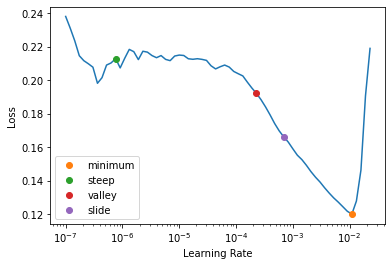

In [17]:
# Just to get an idea, the parameters are not used any further
# Have a look here for further parameter tuning https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,mse,time
0,0.190330,0.085678,0.085678,00:06
1,0.121213,0.039285,0.039285,00:01
2,0.082795,0.010401,0.010401,00:01
3,0.059903,0.004569,0.004569,00:01
4,0.045635,0.003266,0.003266,00:02
5,0.035974,0.002506,0.002506,00:01
6,0.029119,0.002224,0.002224,00:02
7,0.024066,0.002200,0.002200,00:02
8,0.020240,0.002185,0.002185,00:02
9,0.017234,0.002173,0.002173,00:01


Better model found at epoch 0 with valid_loss value: 0.08567774295806885.


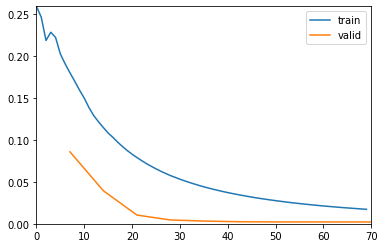

Better model found at epoch 1 with valid_loss value: 0.03928452357649803.
Better model found at epoch 2 with valid_loss value: 0.010401451960206032.
Better model found at epoch 3 with valid_loss value: 0.004569319076836109.
Better model found at epoch 4 with valid_loss value: 0.0032658525742590427.
Better model found at epoch 5 with valid_loss value: 0.0025061550550162792.
Better model found at epoch 6 with valid_loss value: 0.0022239424288272858.
Better model found at epoch 7 with valid_loss value: 0.002200094284489751.
Better model found at epoch 8 with valid_loss value: 0.002184587763622403.
Better model found at epoch 9 with valid_loss value: 0.002172737382352352.


In [18]:
# load - adapt path and name
#learn.load("/content/gdrive/MyDrive/fastai/filename.pth")
learn.fit_one_cycle(epoch, cbs=[ShowGraphCallback(), SaveModelCallback])
# save - adapt path and name
#learn.save("/content/gdrive/MyDrive/fastai/filename.pth") 

# Stats with independent test images

In [25]:
import os
import sys
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster, show
from rasterio import Affine
from rasterio.enums import Resampling
from numpy import savetxt

# adapt this parameter to the maximum height of your training dataset for PSNR processing
max_height = 3150

# adapt paths
path_lr = '/content/gdrive/MyDrive/fastai/data_test_100/lr_us_cc'
# upsampling is done by the algorithm from this path:
path_lr_ds = '/content/gdrive/MyDrive/fastai/data_test_100/lr'
path_hr = '/content/gdrive/MyDrive/fastai/data_test_100/hr'

meanAbsoluteError = []
meanAbsoluteErrorCubic = []

countMAE = 0
countRMSE = 0
countPSNR = 0
countSSI = 0
countMAESlice = 0
countRMSESlice = 0
countPSNRSlice = 0
countSSISlice = 0
totalMAE_lr = 0
totalMAE_sr = 0
totalRMSE_lr = 0
totalRMSE_sr = 0
totalMAX_lr = 0
totalMAX_sr = 0
fileCounter = 0 

# read low resolution images
for file in os.listdir(path_lr):
    current = os.path.join(path_lr, file)
    fileCounter += 1;
    x, y = [], []
    with rasterio.open(current) as src:
        arrayLR = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )        
    max_val_lr = np.amax(arrayLR)
    min_val_lr = np.amin(arrayLR)
    arrayLR = reshape_as_image(arrayLR)
    nsamples, nx, ny = arrayLR.shape
    arrayLR = arrayLR.reshape((nsamples,nx*ny))
    current_lr = os.path.join(path_lr_ds, file)
    f = rasterio.open(current_lr)
    d1 = f.read(1)
    tensorImage = TensorImage([d1])
    tensorImage = (tensorImage - min_val_lr) / (max_val_lr - min_val_lr)
    arraySR = learn.predict(tensorImage)

    arraySR = arraySR[0].numpy()
    
    # recalculate real world values for sr image
    arraySR = arraySR * (max_val_lr - min_val_lr) + min_val_lr
    arraySR = np.squeeze(arraySR, axis=0)
    
    # maximal value of sr image    
    max_val_sr = np.amax(arraySR)
    
    # load hr image to compare images    
    currentHr = os.path.join(path_hr, file)
    with rasterio.open(currentHr) as src:
        arrayHR = src.read(
            out_shape=(
                src.count,
                int(src.height),
                int(src.width)
            )
        )
 
    arrayHR = reshape_as_image(arrayHR)
    nsamples, nx, ny = arrayHR.shape
    arrayHR = arrayHR.reshape((nsamples,nx*ny))
    # slice 15 pixels from border because border effects
    slice_val = 15
    HrSlice = arrayHR[slice_val:-slice_val, slice_val:-slice_val]
    SrSlice = arraySR[slice_val:-slice_val, slice_val:-slice_val]
    LrSlice = arrayLR[slice_val:-slice_val, slice_val:-slice_val]
    
    # calculate the metrics for sr image
    MAE_sr = mean_absolute_error(arrayHR, arraySR)
    RMSE_sr = mean_squared_error(arrayHR, arraySR, squared=False)
    SSI_sr = structural_similarity(arrayHR, arraySR)
    MAE_sr_slice = mean_absolute_error(HrSlice, SrSlice)
    RMSE_sr_slice = mean_squared_error(HrSlice, SrSlice, squared=False)
    SSI_sr_slice = structural_similarity(HrSlice, SrSlice)
    MAX_sr = np.amax(abs(arrayHR - arraySR))
    MAX_sr_slice = np.amax(abs(HrSlice - SrSlice))
    # adapt data_range to the maximal overall value  of the dataset
    PSNR_sr = peak_signal_noise_ratio(arrayHR, arraySR, data_range=max_height)
    PSNR_sr_slice = peak_signal_noise_ratio(HrSlice, SrSlice, data_range=max_height)
    
    # calculate the metrics for lr image
    MAE_lr = mean_absolute_error(arrayHR, arrayLR)
    RMSE_lr = mean_squared_error(arrayHR, arrayLR, squared=False)
    SSI_lr = structural_similarity(arrayHR, arrayLR)
    MAE_lr_slice = mean_absolute_error(HrSlice, LrSlice)
    RMSE_lr_slice = mean_squared_error(HrSlice, LrSlice, squared=False)
    SSI_lr_slice = structural_similarity(HrSlice, LrSlice)
    MAX_lr = np.amax(abs(arrayHR - arrayLR))
    MAX_lr_slice = np.amax(abs(HrSlice - LrSlice))
    # adapt data_range to the maximal overall value  of the dataset
    PSNR_lr = peak_signal_noise_ratio(arrayHR, arrayLR, data_range=max_height)
    PSNR_lr_slice = peak_signal_noise_ratio(HrSlice, LrSlice, data_range=max_height)
    
    # MAE count improved images
    if MAE_sr < MAE_lr:
        countMAE += 1
    if MAE_sr_slice < MAE_lr_slice:
        countMAESlice += 1    
    # RMSE count improved images
    if RMSE_sr < RMSE_lr:
        countRMSE += 1
    if RMSE_sr_slice < RMSE_lr_slice:
        countRMSESlice += 1 
    # PSNR count imporved images, higher values are better
    if PSNR_sr > PSNR_lr:
        countPSNR += 1
    if PSNR_sr_slice > PSNR_lr_slice:
        countPSNRSlice += 1    
    # SSI count imporved images, higher values are better
    if SSI_sr > SSI_lr:
        countSSI += 1
    if SSI_sr_slice > SSI_lr_slice:
        countSSISlice += 1

    totalMAE_lr = totalMAE_lr + MAE_lr_slice
    totalMAE_sr = totalMAE_sr + MAE_sr_slice
    totalRMSE_lr = totalRMSE_lr + RMSE_lr_slice
    totalRMSE_sr = totalRMSE_sr + RMSE_sr_slice        
    totalMAX_lr = totalMAX_lr + MAX_lr_slice
    totalMAX_sr = totalMAX_sr + MAX_sr_slice 

    # print metrics for every tile if desired
    #print(file ,' SR MaxError: ', MAX_sr_slice  ,' LR MaxError: ', MAX_lr_slice, ' Difference MaxError LR - SR: ', MAX_lr_slice - MAX_sr_slice)
    #print(file ,' SR MAE: ', MAE_sr_slice ,' LR MAE: ', MAE_lr_slice, ' Difference LR - SR: ', MAE_lr_slice - MAE_sr_slice)
    #print(file ,' SR RMSE: ', RMSE_sr_slice ,' LR RMSE: ', RMSE_lr_slice, ' Difference LR - SR: ', RMSE_lr_slice - RMSE_sr_slice)
    #print(file ,' SR PSNR: ', PSNR_sr_slice ,' LR PSNR: ', PSNR_lr_slice, ' Difference LR - SR: ', PSNR_lr_slice - PSNR_sr_slice)

print('Mean MAE LR', totalMAE_lr/fileCounter);
print('Mean MAE SR', totalMAE_sr/fileCounter);
print('Difference LR - SR MAE ', totalMAE_lr/fileCounter - totalMAE_sr/fileCounter)
print('Mean RMSE LR', totalRMSE_lr/fileCounter);
print('Mean RMSE SR', totalRMSE_sr/fileCounter);
print('Difference SR - LR RMSE ', totalRMSE_lr/fileCounter - totalRMSE_sr/fileCounter)
print('MAX LR', totalMAX_lr/fileCounter);
print('MAX SR', totalMAX_sr/fileCounter);
print('Difference LR - SR MAX ', totalMAX_lr/fileCounter - totalMAX_sr/fileCounter)

Mean MAE LR 0.8654804018139839
Mean MAE SR 40.828428745269775
Difference LR - SR MAE  -39.96294834345579
Mean RMSE LR 1.5166528463363647
Mean RMSE SR 53.91793758392334
Difference SR - LR RMSE  -52.40128473758698
MAX LR 24.815706787109374
MAX SR 242.4800946044922
Difference LR - SR MAX  -217.66438781738282
